In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "xgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-15 14:36:55.752888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 14:36:56.164532: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 14:36:57.346224: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_138


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [13:13<00:00,  2.86s/it]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,onset_oof,onset_oof_diff_abs,...,wakeup_oof_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,same_count_rolling_square_mean_100_shift_1000,onset_oof_rolling_square_mean_100_shift_1000,wakeup_oof_rolling_square_mean_100_shift_1000,reduce_step,fold
27,-88.1875,0.085938,0.085938,-12.085938,0.029175,0.000293,0.030487,597.5,0.000102,4.172325e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,659,3
28,-88.5000,0.101562,0.101562,-7.546875,0.029114,0.000434,0.051453,717.5,0.000112,3.576279e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,683,3
29,-89.2500,0.052094,0.052094,-10.070312,0.029861,0.000266,0.104065,837.5,0.000122,4.768372e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,707,3
30,-87.4375,0.151001,0.151001,-0.726562,0.029465,0.000533,0.095032,957.5,0.000140,9.536743e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,731,3
31,-86.2500,0.174438,0.174438,-5.722656,0.030289,0.001756,0.092041,1078.0,0.000154,9.536743e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,755,3


(471955, 2279)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["xgboost"], 
        es_rounds=200,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.54607
[100]	eval-rmse:1.08600
[200]	eval-rmse:0.97673
[300]	eval-rmse:0.94655
[400]	eval-rmse:0.93742
[500]	eval-rmse:0.93380
[600]	eval-rmse:0.93173
[700]	eval-rmse:0.93065
[800]	eval-rmse:0.93009
[900]	eval-rmse:0.92956
[1000]	eval-rmse:0.92927
[1100]	eval-rmse:0.92907
[1200]	eval-rmse:0.92890
[1300]	eval-rmse:0.92875
[1400]	eval-rmse:0.92871
[1500]	eval-rmse:0.92847
[1600]	eval-rmse:0.92832
[1700]	eval-rmse:0.92838
[1800]	eval-rmse:0.92837
[1839]	eval-rmse:0.92841


 20%|██        | 1/5 [02:32<10:11, 152.85s/it]

== fold 1 ==
[0]	eval-rmse:1.53484
[100]	eval-rmse:1.06435
[200]	eval-rmse:0.97718
[300]	eval-rmse:0.96213
[400]	eval-rmse:0.95918
[500]	eval-rmse:0.95842
[600]	eval-rmse:0.95782
[700]	eval-rmse:0.95723
[800]	eval-rmse:0.95651
[900]	eval-rmse:0.95591
[1000]	eval-rmse:0.95547
[1100]	eval-rmse:0.95520
[1200]	eval-rmse:0.95493
[1300]	eval-rmse:0.95462
[1400]	eval-rmse:0.95450
[1500]	eval-rmse:0.95427
[1600]	eval-rmse:0.95411
[1700]	eval-rmse:0.95402
[1800]	eval-rmse:0.95394
[1900]	eval-rmse:0.95380
[2000]	eval-rmse:0.95369
[2100]	eval-rmse:0.95356
[2200]	eval-rmse:0.95348
[2300]	eval-rmse:0.95353
[2381]	eval-rmse:0.95353


 40%|████      | 2/5 [05:45<08:49, 176.38s/it]

== fold 2 ==
[0]	eval-rmse:1.59479
[100]	eval-rmse:1.12884
[200]	eval-rmse:1.04813
[300]	eval-rmse:1.03387
[400]	eval-rmse:1.02912
[500]	eval-rmse:1.02658
[600]	eval-rmse:1.02540
[700]	eval-rmse:1.02493
[800]	eval-rmse:1.02433
[900]	eval-rmse:1.02403
[1000]	eval-rmse:1.02380
[1100]	eval-rmse:1.02360
[1200]	eval-rmse:1.02333
[1300]	eval-rmse:1.02331
[1400]	eval-rmse:1.02334
[1500]	eval-rmse:1.02324
[1600]	eval-rmse:1.02322
[1700]	eval-rmse:1.02305
[1800]	eval-rmse:1.02294
[1900]	eval-rmse:1.02281
[2000]	eval-rmse:1.02273
[2100]	eval-rmse:1.02274
[2200]	eval-rmse:1.02286
[2227]	eval-rmse:1.02283


 60%|██████    | 3/5 [08:50<06:00, 180.07s/it]

== fold 3 ==
[0]	eval-rmse:1.57076
[100]	eval-rmse:1.10747
[200]	eval-rmse:1.00664
[300]	eval-rmse:0.98351
[400]	eval-rmse:0.97826
[500]	eval-rmse:0.97625
[600]	eval-rmse:0.97527
[700]	eval-rmse:0.97441
[800]	eval-rmse:0.97414
[900]	eval-rmse:0.97378
[1000]	eval-rmse:0.97353
[1100]	eval-rmse:0.97315
[1200]	eval-rmse:0.97252
[1300]	eval-rmse:0.97238
[1400]	eval-rmse:0.97223
[1500]	eval-rmse:0.97195
[1600]	eval-rmse:0.97160
[1700]	eval-rmse:0.97144
[1800]	eval-rmse:0.97125
[1900]	eval-rmse:0.97126
[2000]	eval-rmse:0.97134
[2100]	eval-rmse:0.97127
[2200]	eval-rmse:0.97113
[2300]	eval-rmse:0.97111
[2400]	eval-rmse:0.97100
[2500]	eval-rmse:0.97110
[2572]	eval-rmse:0.97111


 80%|████████  | 4/5 [12:14<03:09, 189.85s/it]

== fold 4 ==
[0]	eval-rmse:1.58985
[100]	eval-rmse:1.09245
[200]	eval-rmse:0.99835
[300]	eval-rmse:0.98281
[400]	eval-rmse:0.97968
[500]	eval-rmse:0.97865
[600]	eval-rmse:0.97854
[700]	eval-rmse:0.97839
[800]	eval-rmse:0.97840
[900]	eval-rmse:0.97833
[1000]	eval-rmse:0.97829
[1074]	eval-rmse:0.97832


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.54550
[100]	eval-rmse:1.05204
[200]	eval-rmse:0.94473
[300]	eval-rmse:0.92165
[400]	eval-rmse:0.91562
[500]	eval-rmse:0.91323
[600]	eval-rmse:0.91253
[700]	eval-rmse:0.91260
[800]	eval-rmse:0.91278
[802]	eval-rmse:0.91278


 20%|██        | 1/5 [01:10<04:42, 70.58s/it]

== fold 1 ==
[0]	eval-rmse:1.53416
[100]	eval-rmse:1.03138
[200]	eval-rmse:0.92659
[300]	eval-rmse:0.90398
[400]	eval-rmse:0.89809
[500]	eval-rmse:0.89559
[600]	eval-rmse:0.89401
[700]	eval-rmse:0.89350
[800]	eval-rmse:0.89290
[900]	eval-rmse:0.89255
[1000]	eval-rmse:0.89224
[1100]	eval-rmse:0.89206
[1200]	eval-rmse:0.89178
[1300]	eval-rmse:0.89163
[1400]	eval-rmse:0.89151
[1500]	eval-rmse:0.89149
[1600]	eval-rmse:0.89147
[1700]	eval-rmse:0.89145
[1800]	eval-rmse:0.89146
[1830]	eval-rmse:0.89150


 40%|████      | 2/5 [03:40<05:51, 117.12s/it]

== fold 2 ==
[0]	eval-rmse:1.59517
[100]	eval-rmse:1.17465
[200]	eval-rmse:1.08112
[300]	eval-rmse:1.05587
[400]	eval-rmse:1.04808
[500]	eval-rmse:1.04418
[600]	eval-rmse:1.04292
[700]	eval-rmse:1.04311
[773]	eval-rmse:1.04309


 60%|██████    | 3/5 [04:48<03:09, 94.93s/it] 

== fold 3 ==
[0]	eval-rmse:1.56281
[100]	eval-rmse:1.10743
[200]	eval-rmse:1.02262
[300]	eval-rmse:1.00794
[400]	eval-rmse:1.00566
[500]	eval-rmse:1.00550
[600]	eval-rmse:1.00529
[700]	eval-rmse:1.00510
[800]	eval-rmse:1.00484
[900]	eval-rmse:1.00478
[1000]	eval-rmse:1.00485
[1085]	eval-rmse:1.00491


 80%|████████  | 4/5 [06:21<01:34, 94.20s/it]

== fold 4 ==
[0]	eval-rmse:1.58600
[100]	eval-rmse:1.13193
[200]	eval-rmse:1.04315
[300]	eval-rmse:1.02326
[400]	eval-rmse:1.01856
[500]	eval-rmse:1.01700
[600]	eval-rmse:1.01645
[700]	eval-rmse:1.01627
[800]	eval-rmse:1.01619
[900]	eval-rmse:1.01614
[1000]	eval-rmse:1.01618
[1100]	eval-rmse:1.01614
[1200]	eval-rmse:1.01622
[1300]	eval-rmse:1.01603
[1400]	eval-rmse:1.01615
[1497]	eval-rmse:1.01610


100%|██████████| 5/5 [08:23<00:00, 100.77s/it]


## Dynamic-Range NMS

<AxesSubplot: >

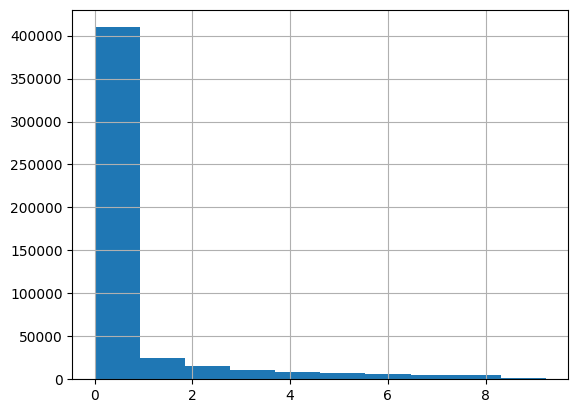

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:05<00:00, 51.25it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7964


event   tolerance
onset   12           0.310222
        36           0.711488
        60           0.797291
        90           0.839200
        120          0.854720
        150          0.866866
        180          0.877041
        240          0.889488
        300          0.895389
        360          0.901688
wakeup  12           0.278617
        36           0.732723
        60           0.810244
        90           0.839945
        120          0.858416
        150          0.870347
        180          0.879978
        240          0.894629
        300          0.905367
        360          0.914596
dtype: float64